## Sentiment Analysis
#### **Sentiment Analysis**. The idea is that we will equip our students with nothing beforehand and we will build a Sentiment Analysis "solution" from scratch quickly. 
In first two sessions, we will cover the following:  
* Some basic text processing (to handle comments, feedbacks, reviews, complaints).
* A bit of feature engineering to extract relevant information for Sentiment Analysis task.
* How to build and run a basic ML model on those features for Sentiment Analysis task. In this part, we will have a deep review on Logistic Regression and Naïve Bayes models in NLP context.

Note: For the sake of simplicity and some illustration purpose, we will put everything in one single jupyter notebook. It means that I will ignore any kind of OOP principles for a while :) 




### Lib importation and data download

In [1]:
import nltk #Natural Language Toolkit
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\PHUC\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PHUC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Twitter sample data
* The `twitter_samples` contains 5000 positive_tweets, 5000 negative_tweets, hence 10000 samples in total.
* Each tweet is associated with a sentiment (a label). A positive tweet is labeled as 1 and a negative one is labeled as 0.
* We use 80% data to train a model and 20% data for testing.

### Problem:
We are in a typical framework for Sentiment Analysis where we would love to create some sort of algorithm to determine whether the sentiment of a sentence (a tweet in this case) is positive or negative. 

In [3]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
# split data into train and test set
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [5]:
# Create the numpy array of positive labels and negative labels.
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [6]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


Let's take a quick look into our data

In [7]:
print('the tweet in train set is: ', train_x[108])

the tweet in train set is:  @UKBusinessLunch Hi we will be joining you again today :)


In [8]:
print('the 1001-th tweet in test set: ', test_x[1450])

the 1001-th tweet in test set:  someone say thank u and goodbye to chris for me tomorrow pls :(


## PART I - Data preprocessing
Basic steps for data preprocessing:
* Punctuation Removal
* Lowering the Text
* Tokenization i.e. split a tweet into words
* Stop Word Removal: Stopwords are the commonly used words and are removed from the text as they do not add any value to the analysis
* Stemming: Words are stemmed or diminished to their root/base form.  For example, ‘programmer’, ‘programming, ‘program’ are stemmed to ‘program’

Output: each tweet is transformed into a list of "words" (they are not 100% usual English words because of stemming operation).


In [9]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def process_tweet(tweet):
    """
    Input:
        :tweet: a string
    Output:
        :tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean

In [10]:
print(train_x[6])
print(process_tweet(train_x[6]))

We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI
['like', 'keep', 'love', 'custom', 'wait', 'long', 'hope', 'enjoy', 'happi', 'friday', 'lwwf', ':)']


In [11]:
print(test_x[11])
print(process_tweet(test_x[11]))

@EllieVond @SkeletonSweets @Justin_Naito @justcallmerizzo No actually, you don't. Bye bye indeed. Go take your drama elsewhere. :)
['actual', 'bye', 'bye', 'inde', 'go', 'take', 'drama', 'elsewher', ':)']


## PART II - Feature engineering
Basically, machine models are made by mathematical formulae, hence, they can only understand numerical structures. Hence, we have to extract from our text data (tweets) specific information (<b>feature</b>) which are numerically interpretable and are linked to our goal (Sentiment Analysis). <br>
In the present Sentiment Analysis problem, we want to build a machine which is capable of reading a tweet and tell us whether this tweet has a positive or negative sentiment. <br>
   
* We build a frequency dictionary {(word, label): freq} which count the number of times (frequency) that the word is associated with the label. 
    * For example, ('happy', 1): 14 means that the word "happy" appears in positive tweets 14 times.
* Given a list of tweets, we will extract two features and store them into a matrix
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 

### PART II.1 - Build a frequency dictionary

In [12]:
def build_freqs(tweets, ys):
    """ Build frequencies
    Input:
    tweets: a list of tweets
    ys: an mx1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    yslist = np.squeeze(ys).tolist()
    # start with an empty dict and populate it by looping over all tweets
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [13]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11397


Let's take a look into our frequency dictionary

In [14]:
freqs

{('followfriday', 1.0): 23,
 ('top', 1.0): 30,
 ('engag', 1.0): 7,
 ('member', 1.0): 14,
 ('commun', 1.0): 27,
 ('week', 1.0): 72,
 (':)', 1.0): 2960,
 ('hey', 1.0): 60,
 ('jame', 1.0): 7,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 81,
 ('call', 1.0): 27,
 ('contact', 1.0): 4,
 ('centr', 1.0): 1,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 6,
 ('assist', 1.0): 1,
 ('mani', 1.0): 28,
 ('thank', 1.0): 522,
 ('listen', 1.0): 15,
 ('last', 1.0): 39,
 ('night', 1.0): 55,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 41,
 ('track', 1.0): 5,
 ('scotland', 1.0): 2,
 ('congrat', 1.0): 15,
 ('yeaaah', 1.0): 1,
 ('yipppi', 1.0): 1,
 ('accnt', 1.0): 2,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 57,
 ('blue', 1.0): 8,
 ('tick', 1.0): 1,
 ('mark', 1.0): 1,
 ('fb', 1.0): 4,
 ('profil', 1.0): 2,
 ('15', 1.0): 4,
 ('day', 1.0): 187,
 ('one', 1.0): 92,
 ('irresist', 1.0): 2,
 ('flipkartfashionfriday', 1.0): 16,
 ('like', 1.0): 187,
 ('keep', 1.0): 55,
 ('love', 1.0): 336,
 

### PART II.2 - Feature extraction
Implement extract_features function:
* This function takes in a single tweet.
* Process the tweet using `process_tweet` function and save the list of tweet words.
* Loop through each word in the list of processed words
    * For each word, check the 'freqs' dictionary for the count when that word has a positive '1' label. (value associated with the key (word, 1.0)
    * Do the same for the count for when the word is associated with the negative label '0'. (value associated with the key (word, 0.0).)

In [15]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]
        
    assert(x.shape == (1, 3))
    return x

In [16]:
train_x[8]

'Jgh , but we have to go to Bayan :D bye'

In [17]:
extract_features(train_x[8], freqs)

array([[  1., 656., 189.]])

In [18]:
process_tweet(train_x[8])

['jgh', 'go', 'bayan', ':d', 'bye']

## Part III - Logistic regression 

### Part III.1 - Sigmoid
You will learn to use logistic regression for text classification. 
* The sigmoid function is defined as: 

$$ \sigma(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./sigmoid_function.png' alt="alternate text" width="width" height="height" style="width:800px;height:400px;"/> </div>

In [19]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    ''' 
    h = 1. / (1. + np.exp(-z))
    return h

### PART III.2 - Logistic regression

Logistic regression takes a regular linear regression, and applies a sigmoid to the output of the linear regression.

#### Regression (logit)
$$z = w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$$
In our case $n$ is equal to $2$.

#### The prediction
$$ y_{\text{pred}} = \sigma(z) = \frac{1}{1+\exp^{-z}}$$

#### Loss function (binary log-loss)
$$J(w) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (y_{\text{pred}}^{(i)}) + (1-y^{(i)})\log (1-y_{\text{pred}}^{(i)})$$
* $w = (w_0, w_1, w_2)$ is model parameters
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The goal of a training process is to minimize the loss function $J(w)$ on the training set.


#### Gradient descent

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./gradient_descent.png' alt="alternate text" width="width" height="height" style="width:800px;height:400px;"/> </div>

Compute the gradient
$$\dfrac{\partial J}{\partial w_j} (w) = \frac{1}{m} \sum_{i=1}^m(y_{\text{pred}}^{(i)}-y^{(i)})x^{(i)}_j$$
Update the weights $w$
$$w_j = w_j - \alpha \dfrac{\partial J}{\partial w_j} (w)$$

#### Matrix form and implementation
* $w$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $w_0$
* The 'logits', 'z', are calculated by multiplying the feature matrix $X$ with the weight vector $w$ i.e. $z = Xw$
    * $X$ has dimensions (m, n+1) 
    * $w$: has dimensions (n+1, 1)
    * $z$: has dimensions (m, 1)
* The prediction $y_{\text{pred}}$, is calculated by applying the sigmoid to $z$, and has dimensions (m,1).
* The cost function $J$ in its vector form
$$J = -\frac{1}{m} \times \left(y^T \cdot log(y_{\text{pred}}) + (1-y)^T \cdot log(1 - y_{\text{pred}}) \right)$$
* The update of $w$ is also vectorized
$$w = w - \frac{\alpha}{m} \times \left( X^T \cdot \left(y_{\text{pred}} - y\right) \right)$$



In [20]:
import matplotlib.pyplot as plt

def gradient_descent_logistic(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix X
    m = len(x)
    losses = []
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = - (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) / float(m)
        losses.append(float(J))
        # update the weights theta
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)
    
    J = float(J)
    
    # plot the loss function
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta

#### Expected output
```
The cost after training is 0.67094970.
The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]
```

### PART III.3 - Logistic Regression training

* Stack the features for all training examples into a matrix X. 
* Call gradient_descent_logistic function.

C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


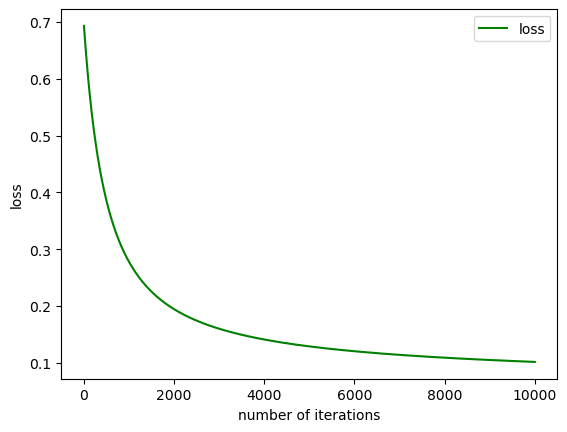

The cost after training is 0.10157921.
The resulting vector of weights is [np.float64(3e-07), np.float64(0.00127323), np.float64(-0.001111)]


In [21]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

Note: If we set the iteration at 100000, you might encounter the problem dividing by zero in the log. Correct this issue.

In [22]:
# Save the weights (a numpy array) in a binary .npy format.
np.save("sentiment_analysis_logistic_weights.npy",w)

In [23]:
w = np.load("sentiment_analysis_logistic_weights.npy")
w 

array([[ 3.03801795e-07],
       [ 1.27323059e-03],
       [-1.11100055e-03]])

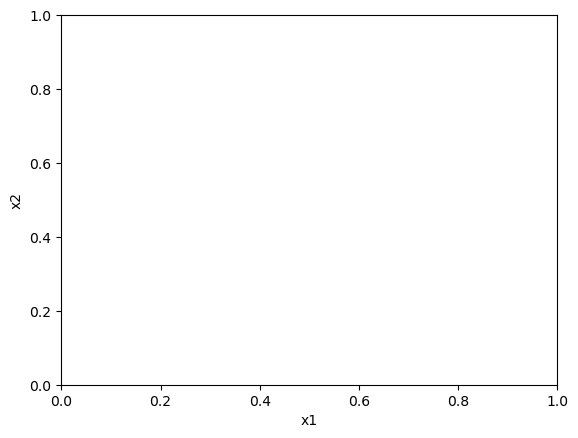

In [24]:
# Plot the decision boundary
x1 = np.arange(0, 10000, 10)
x2 = np.arange(0, 10000, 10)

x1, x2 = np.meshgrid(x1, x2)
params = np.squeeze(w)
g = params[0] + params[1] * x1 + params[2] * x2

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x1, x2, g)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

#### Write a function to predict whether a tweet is positive or negative.
* Given a tweet, process it, then extract the features.
* Apply the model's learned weights $w$ on the features to get the logits.
* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = \sigma(X \cdot w)$$

In [25]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [26]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, w)))    

I am happy -> 0.546432
I am bad -> 0.489459
this movie should have been great. -> 0.539413
great -> 0.538728
great great -> 0.576993
great great great -> 0.614357
great great great great -> 0.650420


C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3490015410.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, w)))


In [27]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am so hot'
predict_tweet(my_tweet, freqs, w)

array([[0.5038664]])

#### Determine the model precision 
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0. 0.5 plays a role of the decision threshold here.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by $n$.


In [28]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """   
    # the list for storing predictions
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy

In [29]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, w)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9960


### PART III.4 - Error Analysis

Analyze certain examples that our logistic regression algorithm predicted wrongly

In [30]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, w)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.47137167	b'uff itna miss karhi thi ap :p'
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.53251630	b'u prob fun david'


C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\2367174779.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	0.50095500	b'pat jay'
THE TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	0.50032454	b'whatev stil l young >:-('
THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	0.50000008	b'belov grandmoth'
THE TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours : (
THE PROCESSED TWEET IS: ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20', 'year', 'alway', 'favour']
0	0.50564988	b'that life get call peopl havent seen 20 year alway favour'
THE TWEET IS: Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs #Job #Jobs #Hiring
THE PROCESSED TWEET IS: ['sr', 'financi', 'analyst', 'expedia', 'inc', 'bellevu', 'wa', 'financ', 'expediajob', 'job', 'job', 'hire']
0	0.51644293	b'sr financi analyst ex

In [31]:
# Test results
my_tweet = 'Hopefully my very first NLP session is not too boring to you " !!!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, w)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['hope', 'first', 'nlp', 'session', 'bore']
[[0.51525702]]
Positive sentiment


### Task 5

In [32]:
def precision_lr(test_x, test_y, freqs, theta):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = predict_tweet(tweet, freqs, theta)
        if predicted > 0.5:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
    precision = true_pos / (true_pos + false_pos)
    return precision

In [33]:
# New decision function g(s)
def classify_tweet(tweet, freqs):
    x = extract_features(tweet, freqs)
    if x[0,1] > x[0,2]:
        y_pred = 1
    else:
        y_pred = 0
    return y_pred

In [34]:
def precision_gfunc(test_x, test_y, freqs):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = classify_tweet(tweet, freqs)
        if predicted == 1:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
    precision = true_pos / (true_pos + false_pos)
    return precision

In [35]:
pre_lr = precision_lr(test_x, test_y, freqs, w)
print(f"Logistic regression model's precision = {pre_lr:.4f}")

Logistic regression model's precision = 0.9930


In [36]:
pre_gfunc = precision_gfunc(test_x, test_y, freqs)
print(f"g(s) function's precision = {pre_gfunc:.4f}")

g(s) function's precision = 0.9960


#### => It can be seen that the accuracy of the function g(s) is higher than the accuracy of the logistic regression model. This is because the function g(s) is based only on the number of positive words compared to the number of negative words, whereas the logistic regression model relies on the interactions and correlations between the features.

### Task 6

In [37]:
def extract_6_features(tweet, freqs, process_tweet=process_tweet):
    word_l = process_tweet(tweet)
    
    x = np.zeros((1, 7)) 
    
    x[0,0] = 1

    for word in word_l:
        if (word, 1) in freqs.keys():
            x[0,1] += 1 # x1
        
        if (word, 0) in freqs.keys():
            x[0,2] += 1 # x2
    
    x[0,3] = 1 if 'no' in tweet.lower().split() else 0 # x3

    for word in word_l:
        if word in ['I', 'we', 'you']:
            x[0,4] += 1 # x4

    x[0,5] = 1 if '!' in tweet else 0 # x5

    x[0,6] = np.log(len(word_l) + 1) # x6

    assert(x.shape == (1, 7))
    return x

#### Logistic Regression training (model 6 features)

C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3353328855.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3353328855.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


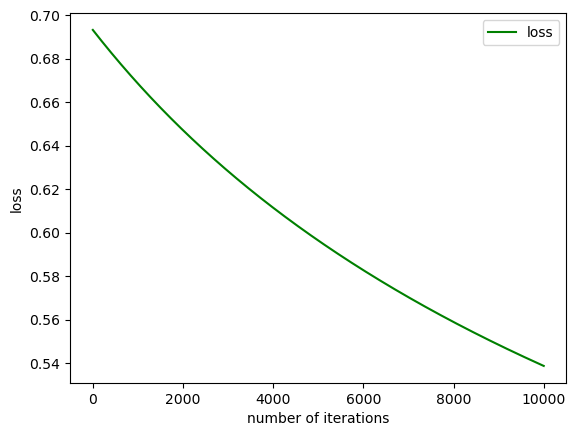

The cost after training is 0.53866249.
The resulting vector of weights is [np.float64(-0.00446829), np.float64(0.27324475), np.float64(-0.27426406), np.float64(-0.00419396), np.float64(5.275e-05), np.float64(0.03312801), np.float64(-0.00026154)]


In [48]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 7))
for i in range(len(train_x)):
    X[i, :]= extract_6_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((7, 1)), 1e-4, 10000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

#### Write a function to predict whether a tweet is positive or negative (model 6 features)

In [39]:
def predict_tweet(tweet, freqs, theta):
    x = extract_6_features(tweet, freqs)

    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [40]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, w)))    

I am happy -> 0.500000
I am bad -> 0.500000
this movie should have been great. -> 0.500000
great -> 0.500000
great great -> 0.500000
great great great -> 0.500000
great great great great -> 0.500000


C:\Users\PHUC\AppData\Local\Temp\ipykernel_12720\3490015410.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, w)))


In [41]:
# Feel free to check the sentiment of your own tweet below
my_tweet = 'I am so hot'
predict_tweet(my_tweet, freqs, w)

array([[0.50000008]])

#### Determine the model precision (6 features)

In [42]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """   
    # the list for storing predictions
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = np.sum(y_hat == np.squeeze(test_y)) / len(test_y)    
    return accuracy

In [43]:
tmp_accuracy_6_features = test_logistic_regression(test_x, test_y, freqs, w)
print(f"Logistic regression model's accuracy (6 features) = {tmp_accuracy_6_features:.4f}")

Logistic regression model's accuracy (6 features) = 0.6260


In [44]:
# Test results
my_tweet = 'Hopefully my very first NLP session is not too boring to you " !!!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, w)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['hope', 'first', 'nlp', 'session', 'bore']
[[0.50000042]]
Positive sentiment
